# 서대문구 공공자전거 수요불균형 문제 파악을 위한 EDA

[목차]
1. 분석 환경 조성
    - 1)라이브러리 호출 및 폰트 설정
    - 2)데이터 프레임 생성
2. 수요 불균형 대여소 선별
    - 1)자치구 필터링
    - 2)분석할 대여소 선별
3. 결론 - 분석 결과 및 인사이트
    - 1)전체적인 분석 인사이트
    - 2)개선 우선순위가 높은 대여소 선정
    - 3)선정 이유

[ 데이터 설명 ]

| **컬럼명** | **설명** | **비고** |
|----------|----------|----------|
| 일시    | 거치대 수량이 집계된 날짜   | *년-월-일*  |
| 대여소 번호    | 대여소 번호   |   |
| 보관소(대여소)명    | 보관소(대여소) 이름  |    |
| 시간대    | 거치대 수량이 집계된 시간대   | *0시 ~ 23시*  |
| 거치대수량    | 해당 시간대에 대여 가능한 자전거 수   |   |
| 자치구    | 대여소가 속한 자치구  |   |
|거치대수    | 대여소에 설치된 거치대 수  | *대여소의 기본 자전거 수량*  |


- 수요 지수 : (거치대 수 - 대여 가능 자전거 수) / (거치대 수)
    - 기본 자전거 수량 대비 얼마나 많은 자전거가 이용 중인가를 나타내는 지수

---
---

### 분석 환경 조성

#### 1) 라이브러리 호출 및 폰트 설정

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap
import os
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# 한글 폰트 설정
plt.rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] =False

# Pandas 보기 옵션 지정
pd.set_option('display.max_columns',100)

#### 2) 데이터 프레임 생성

In [ ]:
# 데이터 프레임생성
df = pd.read_csv("선별자치구_자치구별_대여가능자전거_거치대수.csv", encoding='CP949')
df.head(3)

,Unnamed: 0,일시,대여소 번호,보관소(대여소)명,시간대,거치대수량,자치구,거치대수
0,10,2023-01-01,115,115. 마스타 빌딩 앞,0,13,서대문구,15
1,11,2023-01-01,117,117. 홍은사거리,0,11,서대문구,23
2,17,2023-01-01,123,123. 문화촌 공원,0,13,서대문구,20


In [ ]:
# 'Unnamed: 0' 컬럼 삭제
df = df.drop(columns='Unnamed: 0')

In [ ]:
df.head(3)

,일시,대여소 번호,보관소(대여소)명,시간대,거치대수량,자치구,거치대수
0,2023-01-01,115,115. 마스타 빌딩 앞,0,13,서대문구,15
1,2023-01-01,117,117. 홍은사거리,0,11,서대문구,23
2,2023-01-01,123,123. 문화촌 공원,0,13,서대문구,20


### 수요 불균형 대여소 선별

#### 1) 자치구 필터링

In [ ]:
# 서대문구만 선별
region_df = df[df['자치구'] == '서대문구']
region_df.head(3)

,일시,대여소 번호,보관소(대여소)명,시간대,거치대수량,자치구,거치대수
0,2023-01-01,115,115. 마스타 빌딩 앞,0,13,서대문구,15
1,2023-01-01,117,117. 홍은사거리,0,11,서대문구,23
2,2023-01-01,123,123. 문화촌 공원,0,13,서대문구,20


In [ ]:
region_df.groupby('자치구').mean(numeric_only=True)

,대여소 번호,시간대,거치대수량,거치대수
자치구,,,,
서대문구,1862.583343,11.492893,7.303207,12.050333


In [ ]:
# 원하는 컬럼만 남기기
tmp = region_df.groupby(['보관소(대여소)명','시간대']).mean(numeric_only=True)[['거치대수량','거치대수']]
tmp.head(3)

거치대수량  거치대수
보관소(대여소)명     시간대                
115. 마스타 빌딩 앞 0    5.745163  15.0
              1    5.241493  15.0
              2    5.009465  15.0

- 이전 자치구 선별을 위한 EDA과정에서 데이터 전처리 과정을 거쳤으므로, 여기서는 전처리 과정을 따로 거치지 않는다.

#### 2) 분석할 대여소 선별
- 서대문구 내 수요지수 기준으로 TOP10 대여소를 선별하여 세부적으로 분석한다.

In [ ]:
# 서대문구 내 수요지수 TOP10 대여소 선별
tmp = region_df.groupby(['보관소(대여소)명']).mean(numeric_only=True)[['거치대수량','거치대수']]
tmp['수요지수'] = (tmp['거치대수'] - tmp['거치대수량'])/tmp['거치대수']
a = tmp.sort_values(by='수요지수',ascending=False).head(10)
a

,거치대수량,거치대수,수요지수
보관소(대여소)명,,,
3101. 서대문구청,2.231617,15.0,0.851226
3126.남가좌동 제2공영주차장,1.645973,10.0,0.835403
3111.무악재역 4번 출구,1.903644,10.0,0.809636
138. 신촌동 제1공영주차장 앞,2.011806,10.0,0.798819
159. 이대역 4번 출구,1.008238,5.0,0.798352
137. 신촌기차역입구 교차로,2.122943,10.0,0.787706
3100. 북성초교,1.766452,8.0,0.779194
161. 무악재역1번 출구,1.773941,8.0,0.778257
3116.신촌역 4번출구,2.272552,10.0,0.772745


In [ ]:
# 수요지수 TOP 10 대여소 선별
a.index

Index(['3101. 서대문구청', '3126.남가좌동 제2공영주차장', '3111.무악재역 4번 출구',
       '138. 신촌동 제1공영주차장 앞', '159. 이대역 4번 출구', '137. 신촌기차역입구 교차로',
       '3100. 북성초교', '161. 무악재역1번 출구', '3116.신촌역 4번출구', '4262. 서대문자연사박물관 입구'],
      dtype='object', name='보관소(대여소)명')

In [ ]:
# 선별한 수요지수 TOP10 대여소 데이터 프레임 생성
tmp2 = region_df.groupby(['보관소(대여소)명','시간대']).mean(numeric_only=True)[['거치대수량','거치대수']]
tmp3 = tmp2.reset_index()
tmp_10 = tmp3[tmp3['보관소(대여소)명'].isin(['3101. 서대문구청', '3126.남가좌동 제2공영주차장', '3111.무악재역 4번 출구',
       '138. 신촌동 제1공영주차장 앞', '159. 이대역 4번 출구', '137. 신촌기차역입구 교차로',
       '3100. 북성초교', '161. 무악재역1번 출구', '3116.신촌역 4번출구', '4262. 서대문자연사박물관 입구'])]

In [ ]:
# 테이블 확인
tmp_10.groupby('보관소(대여소)명').sum().index

Index(['137. 신촌기차역입구 교차로', '138. 신촌동 제1공영주차장 앞', '159. 이대역 4번 출구',
       '161. 무악재역1번 출구', '3100. 북성초교', '3101. 서대문구청', '3111.무악재역 4번 출구',
       '3116.신촌역 4번출구', '3126.남가좌동 제2공영주차장', '4262. 서대문자연사박물관 입구'],
      dtype='object', name='보관소(대여소)명')

---

### 데이터 시각화

- 선별된 대여소에서 시간대별 대여 가능 자전거 수량의 변화 추이를 확인하여 이용 패턴을 파악한다.

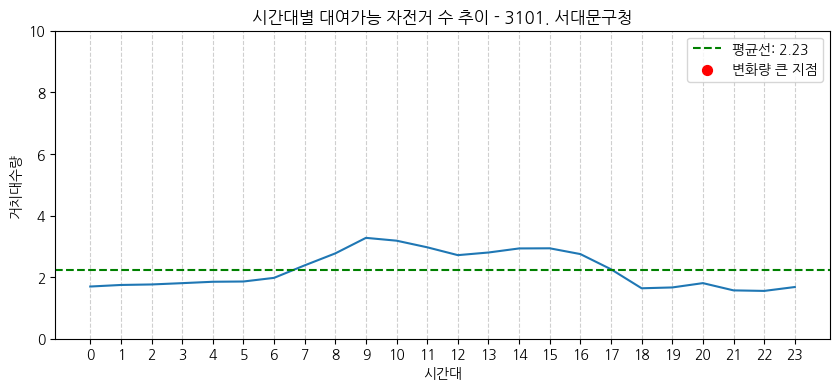

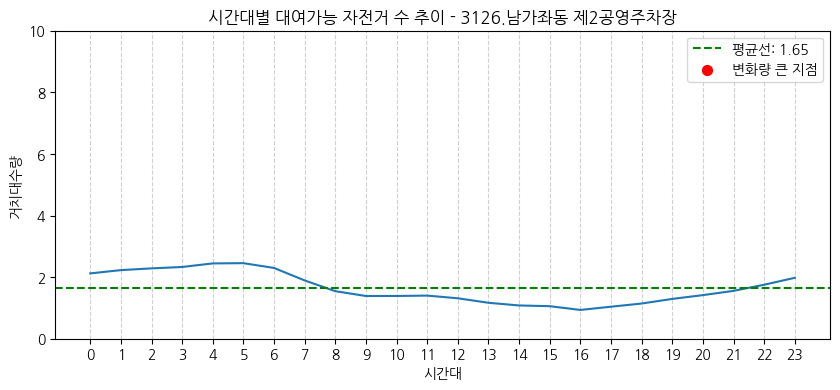

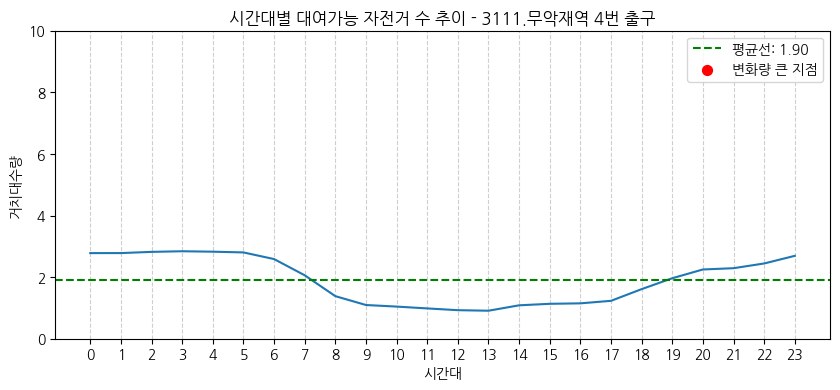

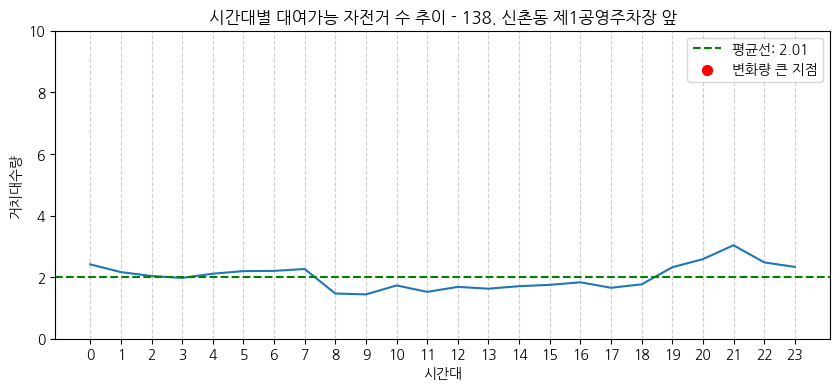

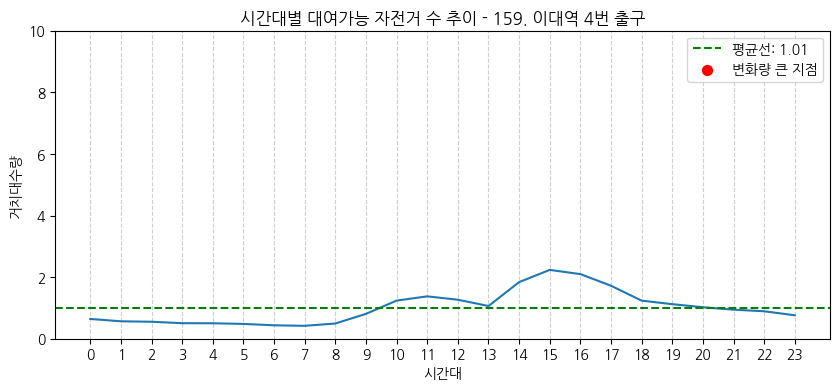

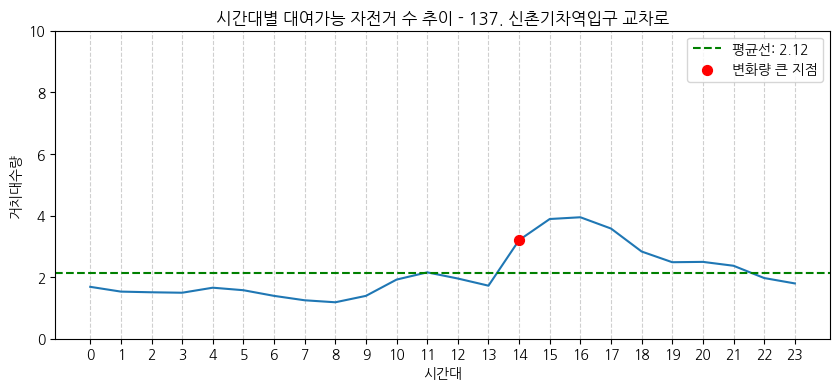

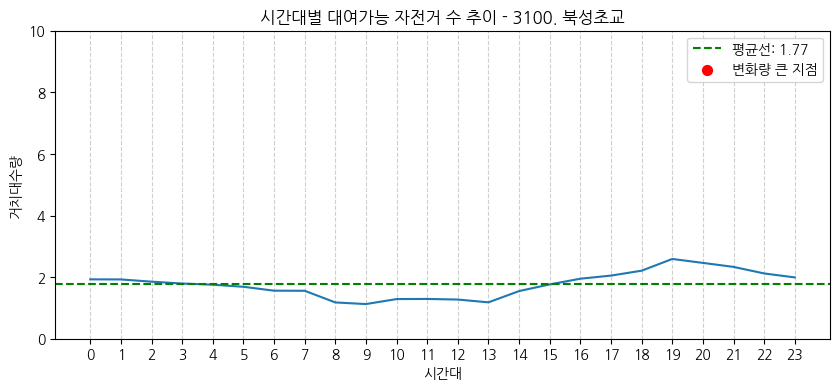

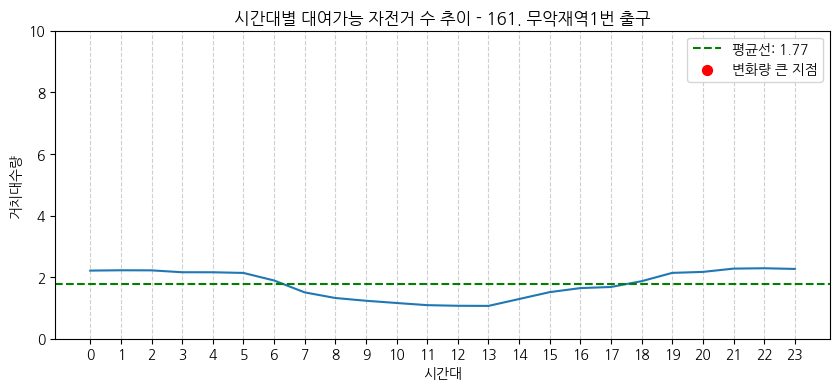

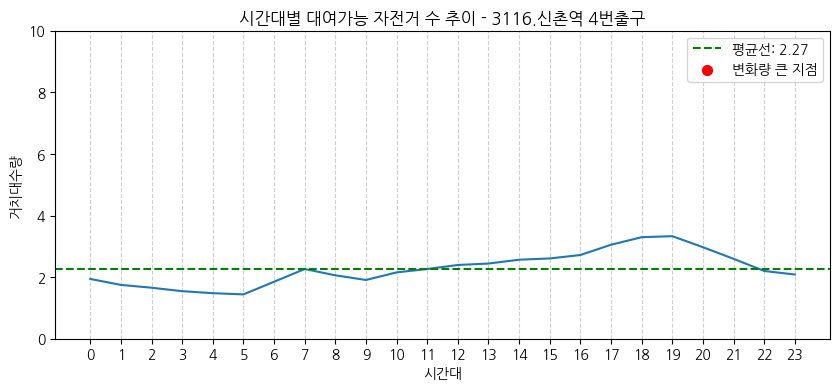

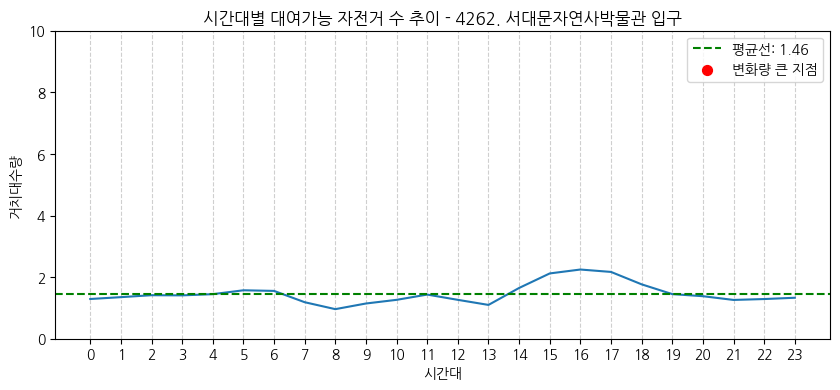

In [ ]:
#수요지수 TOP 10 대여소 시각화
places = ['3101. 서대문구청', '3126.남가좌동 제2공영주차장', '3111.무악재역 4번 출구',
       '138. 신촌동 제1공영주차장 앞', '159. 이대역 4번 출구', '137. 신촌기차역입구 교차로',
       '3100. 북성초교', '161. 무악재역1번 출구', '3116.신촌역 4번출구', '4262. 서대문자연사박물관 입구']

for place in places:
    tmp_df = tmp_10[tmp_10['보관소(대여소)명'] == place]
    tmp_df["변화량"] = tmp_df["거치대수량"].diff().fillna(0).abs()

    #하이라이트 기준 점
    threshold = 1
    highlight = tmp_df[tmp_df["변화량"] > threshold]

    #평균값 계산
    mean_value = tmp_df["거치대수량"].mean()

    plt.figure(figsize=(10,4))
    sns.lineplot(tmp_df,x='시간대',y='거치대수량')

    # 평균선 추가
    plt.axhline(y=mean_value, color="green", linestyle="--", label=f"평균선: {mean_value:.2f}")

    # 변화량 큰 지점
    plt.scatter(
    highlight["시간대"],
    highlight["거치대수량"],
    color="red",
    label="변화량 큰 지점",
    s=50,  # 점 크기
    zorder=3)

    plt.xticks(range(0, 24))
    plt.title(f'시간대별 대여가능 자전거 수 추이 - {place}')
    plt.ylim(0,10)
    plt.legend()
    plt.grid(axis="x", linestyle="--", alpha=0.6)
    plt.show()

- 분석 데이터는 2023년 자료로, 현 시점 폐쇄한 서대문자연사박물관 입구, 남가좌동 제2 공영 주차장은 분석 대상에서 제외하였다.

---
---

### 결론 - 분석 결과 및 인사이트

##### 1) 전체적인 분석 인사이트

1. 출근을 위한 출발지(무악재역 4번출구/1번출구, 신촌동 제1공영주차장 등)에서는 출근 시간대에 대여 가능 자전거 수가 감소하고 퇴근 시간대에 증가하는 U자형 그래프가 나타나며,
   퇴근을 위한 도착지(서대문구청)는 출근 시간대에 대여 가능 자전거 수가 증가하고 퇴근 시간대에 감소하는 종모양 그래프가 나타난다. 이는 출근할 때 출발지에서 대여하고 도착지에서 반납하고, 퇴근할 때 도착지에서 대여하고 출발지에서 반납하는 이용형태로 인한 현상이라고 보인다.

2. 상권이 발달한 신촌역, 이대역 근처 대여소는 주간에 상업시설을 이용하는 방문자들로 인해 대여 가능 자전거 수량이 평균보다 높아지는 현상이 발생한다.

##### 2) 개선 우선순위가 높은 대여소 선정
>선정 기준 : 수요지수 TOP10 내 평균 대여가능 자전거 수량이 낮은 곳
- `3101. 서대문구청`, `3111. 무악재역 4번`

##### 3) 선정 이유
현재 거치대 수 대비 대여가능한 자전거 수가 서대문구에서 가장 적다. (=수요지수가 높음)\
아래 2가지 요인이 해당 대여소의 수요를 증가시키는데 크게 영향을 끼친 것으로 예상되며, 이러한 요인에도 불구하고 거치대 수는 상대적으로 적게 설치되어 다른 대여소 대비 수요 불균형 현상이 비교적 크게 발생하고 있는 것으로 보이기 때문에 해당 대여소 두 곳을 개선 우선순위가 높은 대여소로 선정했다.

1. 두 대여소 간의 연관성
    - 서대문구청은 주변에 지하철역이 존재하지 않고, 그나마 가장 가까운 지하철역이 무악재역이다. 따라서 서대문구청, 근처 보건소, 박물관에에 근무하거나 근처 학교에 통학하는 인원 중 무악재역에서 목적지로 이동하는 인원이 많을 것으로 예상된다.

    - 무악재역에서 서대문구청으로 가려면 버스로 약 20분, 걸어서 약 30분 정도가 소요되나 자전거를 타고가면 약 10분 내외로 최대 3배 이상 이동 시간을 단축시킬 수 있다. 따라서 두 구역간 자전거 이동 수요가 클 것으로 예상된다.

2. 위치적 특성과 유동 인구
    - 서대문구청은 서대문구의 행정 업무를 담당하는 장소로, 공무원, 주민, 방문객 등 유동 인구가 많고, 특히 출퇴근 시간대에 따릉이에 대한 수요가 높다.

    - 구청 인근에는 학교, 주민센터, 관공서 등 다양한 시설이 밀집해 있어 단거리 이동 수요를 창출할 가능성이 크다.

    - 무악재역은 주변에 환승 가능한 지하철역이 존재하지 않는다. 따라서 무악재역을 경유해서 목적지에 가야하는 경우에는 버스나 자전거 등의 교통수단으로 환승할 가능성이 높다.